In [1]:
%matplotlib tk

In [2]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import folium
import geopandas as gpd
from shapely.geometry import Point
from shapely import Polygon
from folium.raster_layers import ImageOverlay
import io
import base64
# plt.style.use('seaborn-v0_8')

In [3]:
""" Load 4D ERA5 data as xarray.core.dataset.Dataset from $DATA

Some important properties
    Latitude 
        Range [44.23337936401367, 46.7599983215332] degrees North
    Longitude
        Range [-75.53164672851562, -71.8677978515625] degrees East
    Rotated Pole
        longitude, latitude [-73.57501220703125,45.5]
    Time scales:
        tas  - hourly
        tmax - daily
        q    - 3 hourly 
"""
# without TEB
tas_n = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/tas.zarr')      
tmax_n= xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/tasmax.zarr')
qn = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/huss.zarr')

# with TEB
tas_t = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/tas.zarr')
tmax_t= xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/tasmax.zarr')
qt = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/huss.zarr')

# static fields
static_fields = xr.open_mfdataset('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_step0.nc')
urban_fraction_2d = static_fields['furban'].isel(lev=5)

In [4]:
# Load ECCC_AHCCD_gen3_temperature data for stations in Canada
pavics = xr.open_dataset("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml")

# Restrict the selection by masking for only stations within the domain
station_is_in_domain = (
    (pavics.lat>44.23337936401367)    & 
    (pavics.lat <46.7599983215332)    & 
    (pavics.lon > -75.53164672851562) & 
    (pavics.lon < -71.8677978515625)
)

# Set the stations into a pandas dataframe
stations = pavics.sel(station=station_is_in_domain).set_coords(['lat', 'lon', 'station_name'])

In [5]:
# Map formatting properties for field projection
bbox = [[44.23337936401367, -75.53164672851562], [46.7599983215332, -71.8677978515625]]
lat_min, lon_min = bbox[0]  # SW corner
lat_max, lon_max = bbox[1]  # NE corner
bounds = [[lat_min, lon_min], [lat_max, lon_max]]  # Fix order

# To project station data onto the map
station_locations = stations[['lat', 'lon', 'station_name']].to_dataframe().reset_index()
geojson_stations = gpd.GeoDataFrame(
    station_locations, geometry=gpd.points_from_xy(station_locations['lon'], station_locations['lat'])
).to_json()

In [18]:
def draw_map(field=None):
    """
    Creates a map and displays the station_locations within the bounds of the simulation on it. 
    It then generates an ImageOverlay of some the static field generated.
    Example usage:
        > f = tmax_n['tasmax'].sel(time='1999-03-08')
        > m = draw_map(f)
        > display(m)

    parameters:
        field - xarray.core.dataarray.DataArray
            The 2D temperature or humidity data 
    returns:
        m - folium.folium.Map
    """
    
    # Initialize the map
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2
    m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

    folium.TileLayer("cartodb positron").add_to(m)

    # Add station markers
    folium.GeoJson(
        geojson_stations,
        popup=folium.GeoJsonPopup(fields=['station_name'], aliases=['Station Name']),
        marker=folium.CircleMarker(radius=3, color='grey', fill=True, fill_color='grey', fill_opacity=0.7)
    ).add_to(m)

    # Overlay field data
    if field is not None:
        # Create an image to store the field data
        image_buffer = io.BytesIO()

        # Matplot seems to render the image well using cells
        fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
        ax.imshow(field.values, cmap="viridis", extent=[lon_min, lon_max, lat_min, lat_max], origin="lower")
        ax.axis("off")  # Remove axes for clean image

        # Save image to buffer
        plt.savefig(image_buffer, format="png", bbox_inches="tight", pad_inches=0, transparent=True)
        plt.close(fig)
        image_buffer.seek(0)
        image_base64 = base64.b64encode(image_buffer.read()).decode()
        image_uri = f"data:image/png;base64,{image_base64}"

        # Read image from buffer and project onto map
        ImageOverlay(
            image=image_uri,
            bounds=bounds,
            opacity=0.6,
            interactive=True,
            cross_origin=False,
            pixelated=True
        ).add_to(m)
    m.fit_bounds(bounds)
    return m


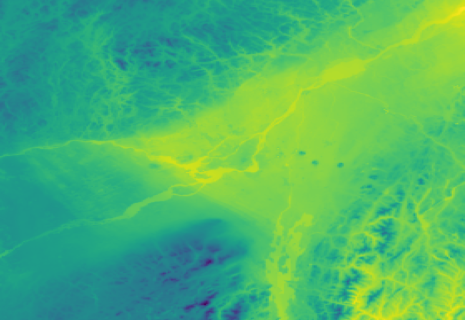

In [19]:
f = tmax_n['tasmax'].sel(time='1999-03-08')
m = draw_map(f)
display(m)